Project 1 - Terrence Cummings
- Crime, Schools, and Home Values in Minneapolis

Step 1 - Property tax assessment data
- Read in housing data from "Open Minneapolis" website using APIs (currently hit 2000 limit. Need to fix.)
- Store in dataframe
- Cleanup data


In [ ]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
import time
from scipy.stats import linregress
import json
from pprint import pprint
from datetime import datetime


In [ ]:
#Initialize lists to hold key home sales data
formatted_address = []
community = []
neighborhood = []
ward = []
zoning =[]
landuse = []
parcel_area_sqft = []
property_type = []
totalvalue = []
multiple_uses = []
main_pt = []
buildinguse = []
yearbuilt = []
belowgroundarea = []
abovegroundarea = []
num_stories = []
garage_present = []
primaryheating = []
constructiontype = []
exteriortype = []
roof = []
total_units = []
fireplaces = []
bathrooms = []
bedrooms = []
assessment_year = []
objectid = []


#Initialize API record offset because of 2000 record limit per API call
resultOffset_num = 0

#Base URL for the Open Minnesota database of home sales in Minneapolis
base_url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Assessors_Parcel_Data_2020/FeatureServer/0/query?where=1%3D1&outFields=FORMATTED_ADDRESS,NEIGHBORHOOD,COMMUNITY,WARD,ZONING,LANDUSE,PARCEL_AREA_SQFT,PROPERTY_TYPE,TOTALVALUE,MULTIPLE_USES,MAIN_PT,BUILDINGUSE,YEARBUILT,BELOWGROUNDAREA,ABOVEGROUNDAREA,NUM_STORIES,GARAGE_PRESENT,PRIMARYHEATING,CONSTRUCTIONTYPE,EXTERIORTYPE,ROOF,TOTAL_UNITS,FIREPLACES,BATHROOMS,BEDROOMS,ASSESSMENT_YEAR,OBJECTID&outSR=4326&f=json'

#Make successive API call to grab 2000 records each time. Total records is 130,719
while resultOffset_num<=500:

#Increment the record offset to get the next batch of records
    resultOffset = str(resultOffset_num)
    resultRecordCount = str(2000)
    resultOffset_num = resultOffset_num+2000

#Dyamically adjust the offset parameter of the API call and create the next target URL
    pagination_url = f'&resultOffset={resultOffset}&resultRecordCount={resultRecordCount}'
    target_url = f'{base_url}{pagination_url}'

#Make the API call and store data
    home_tax_data = requests.get(target_url).json()


#Set the number of home sales in the data for looping in filling the lists of key data
    num_tax_houses=len(home_tax_data['features'])

#Fill lists of key data
    for house in range(0, num_tax_houses):
        formatted_address.append(home_tax_data['features'][house]['attributes']['FORMATTED_ADDRESS'])
        community.append(home_tax_data['features'][house]['attributes']['COMMUNITY'])
        neighborhood.append(home_tax_data['features'][house]['attributes']['NEIGHBORHOOD'])
        ward.append(home_tax_data['features'][house]['attributes']['WARD'])
        zoning.append(home_tax_data['features'][house]['attributes']['ZONING'])
        landuse.append(home_tax_data['features'][house]['attributes']['LANDUSE'])
        parcel_area_sqft.append(home_tax_data['features'][house]['attributes']['PARCEL_AREA_SQFT'])
        property_type.append(home_tax_data['features'][house]['attributes']['PROPERTY_TYPE'])
        totalvalue.append(home_tax_data['features'][house]['attributes']['TOTALVALUE'])
        multiple_uses.append(home_tax_data['features'][house]['attributes']['MULTIPLE_USES'])
        main_pt.append(home_tax_data['features'][house]['attributes']['MAIN_PT'])
        buildinguse.append(home_tax_data['features'][house]['attributes']['BUILDINGUSE'])
        yearbuilt.append(home_tax_data['features'][house]['attributes']['YEARBUILT'])
        belowgroundarea.append(home_tax_data['features'][house]['attributes']['BELOWGROUNDAREA'])
        abovegroundarea.append(home_tax_data['features'][house]['attributes']['ABOVEGROUNDAREA'])
        num_stories.append(home_tax_data['features'][house]['attributes']['NUM_STORIES'])
        garage_present.append(home_tax_data['features'][house]['attributes']['GARAGE_PRESENT'])
        primaryheating.append(home_tax_data['features'][house]['attributes']['PRIMARYHEATING'])
        constructiontype.append(home_tax_data['features'][house]['attributes']['CONSTRUCTIONTYPE'])
        exteriortype.append(home_tax_data['features'][house]['attributes']['EXTERIORTYPE'])
        roof.append(home_tax_data['features'][house]['attributes']['ROOF'])
        total_units.append(home_tax_data['features'][house]['attributes']['TOTAL_UNITS'])
        fireplaces.append(home_tax_data['features'][house]['attributes']['FIREPLACES'])
        bathrooms.append(home_tax_data['features'][house]['attributes']['BATHROOMS'])
        bedrooms.append(home_tax_data['features'][house]['attributes']['BEDROOMS'])
        assessment_year.append(home_tax_data['features'][house]['attributes']['ASSESSMENT_YEAR'])
        objectid.append(home_tax_data['features'][house]['attributes']['OBJECTID']

In [ ]:
len(objectid)

In [37]:
#Create df of all MSP home sales data
msp_home_tax_df = pd.DataFrame(zip(objectid, assessment_year, formatted_address, community, neighborhood, ward, zoning, landuse, parcel_area_sqft, property_type, totalvalue, multiple_uses, main_pt, buildinguse, yearbuilt, belowgroundarea, abovegroundarea, num_stories, garage_present, primaryheating, constructiontype, exteriortype, roof, total_units, fireplaces, bathrooms, bedrooms), columns = ['objectid', 'assessment_year', 'formatted_address', 'community', 'neighborhood', 'ward', 'zoning', 'landuse', 'parcel_area_sqft', 'property_type', 'totalvalue', 'multiple_uses', 'main_pt', 'buildinguse', 'yearbuilt', 'belowgroundarea', 'abovegroundarea', 'num_stories', 'garage_present', 'primaryheating', 'constructiontype', 'exteriortype', 'roof', 'total_units', 'fireplaces', 'bathrooms', 'bedrooms'])

msp_home_tax_df.set_index('objectid', inplace=True)

msp_home_tax_df['totalarea'] = msp_home_tax_df['abovegroundarea'] + msp_home_tax_df['belowgroundarea']


In [70]:
#Clean up df by eliminating very low sale price
clean_msp_home_tax_df = msp_home_tax_df.loc[msp_home_tax_df['totalvalue']>10000]

#Clean up df by eliminating very high sale price
clean_msp_home_tax_df = clean_msp_home_tax_df.loc[clean_msp_home_tax_df['totalvalue']<5000000]

#Clean up by eliminating non-residential and odd property types
zoning_allow = ['R1', 'R1A']
clean_msp_home_tax_df = clean_msp_home_tax_df[clean_msp_home_tax_df['zoning'].isin(zoning_allow)]

#Clean up by eliminating non-residential and odd property types
landuse_allow = ['SINGLE-FAMILY DETACHED DW', 'MULTI-FAMILY RESIDENTIAL', 'SINGLE-FAMILY ATTACHED DW']
clean_msp_home_tax_df = clean_msp_home_tax_df[clean_msp_home_tax_df['landuse'].isin(landuse_allow)]

#drop all nan rows
clean_msp_home_tax_df = clean_msp_home_tax_df.dropna()

#Add Minneapolis, MN to address
clean_msp_home_tax_df['formatted_address'] = clean_msp_home_tax_df['formatted_address']+', Minneapolis, MN'

In [71]:
clean_msp_home_tax_df.to_csv('clean_msp_tax_sales.csv')

In [72]:
#A function which takes in: 1) x data, 2) y data, 3) name for x axis, 4) name for y axis, 5) indicate or whether 
#to draw linear regression or not: TRUE = include linear regression plot, FALSE = do not include linear regression.abs

def get_line(x,y,x_name,y_name, incl_regress):
    
    #Initialize the two plats: ax1=scatter, ax2=linear regression line    
    ax1=[]
    ax2=[]
    
    #count the number of cities in the plot to include in the title
    plot_count = x.count()
    
    #Do scatter plot, titel, and labels
    ax1=plt.scatter(x,y)
    ax1=plt.title(f'{plot_count} plots of {y_name} vs. {x_name}')
    ax1=plt.xlabel(f'{x_name}')
    ax1=plt.ylabel(f'{y_name}')
    
    #Include linear regression plot if flag indicates 
    if incl_regress:
        #Perform linear regression and r2 and plot
        slope, intercept, rvalue, pvalue, stderr = st.linregress(x,y)
        r_squared = rvalue**2
        ax2=plt.plot(x, x*slope+intercept, color='red', label= 'Y= '+str(round(slope,2))+'*X + '+str(round(intercept,2))+' R2='+str(round(r_squared,2)))
        #Use legend to show the linear regression equation and R2 value
        ax2=plt.legend()
        
    
    return ax1, ax2

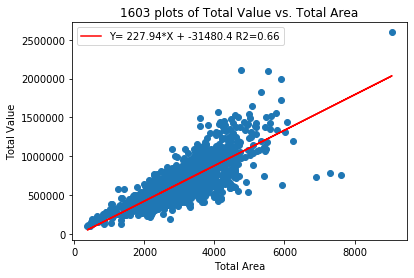

In [73]:
#Plot totalvalue vs totalarea
graph1, graph2 = get_line(clean_msp_home_tax_df['totalarea'], clean_msp_home_tax_df['totalvalue'], 'Total Area', 'Total Value', True)
plt.show()

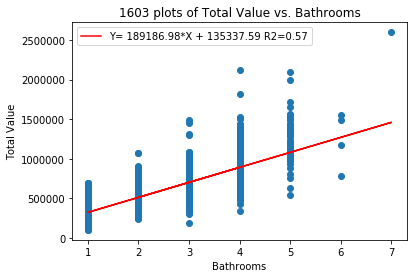

In [74]:
#Plot totalvalue vs bathrooms
graph1, graph2 = get_line(clean_msp_home_tax_df['bathrooms'], clean_msp_home_tax_df['totalvalue'], 'Bathrooms', 'Total Value', True)
plt.show()

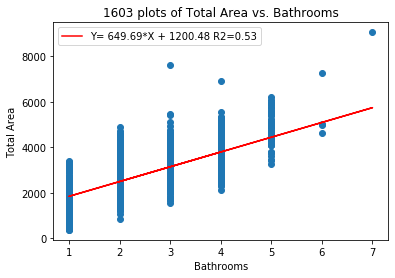

In [75]:
#Plot abovegroundarea vs bathrooms
graph1, graph2 = get_line(clean_msp_home_tax_df['bathrooms'], clean_msp_home_tax_df['totalarea'], 'Bathrooms', 'Total Area', True)
plt.show()

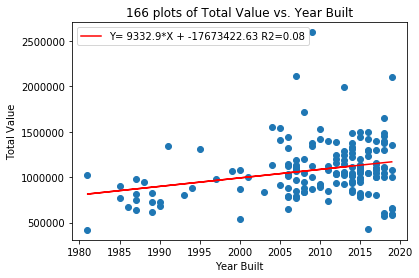

In [78]:
#Plot totalvalue vs year
eighties = clean_msp_home_tax_df.loc[clean_msp_home_tax_df['yearbuilt']>1979]
graph1, graph2 = get_line(eighties['yearbuilt'], eighties['totalvalue'], 'Year Built', 'Total Value', True)
plt.show()

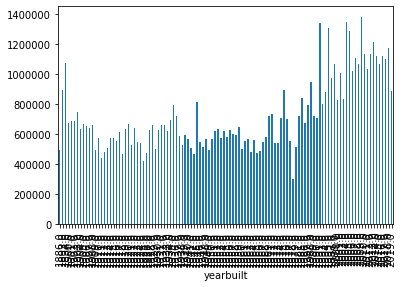

In [62]:
year_grp = clean_msp_home_tax_df.groupby('yearbuilt')['totalvalue'].mean()

year_grp.plot.bar()


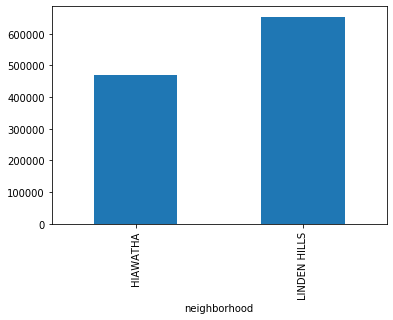

In [63]:
neighborhood_grp = clean_msp_home_tax_df.groupby('neighborhood')['totalvalue'].mean()

neighborhood_grp.plot.bar()


In [79]:
clean_msp_home_tax_df['neighborhood'].value_counts()

LINDEN HILLS    1370
HIAWATHA         233
Name: neighborhood, dtype: int64